# Computing the Jacobian Matrix at the Equilibrium Point 

In [60]:
using ChebyshevApprox
using ForwardDiff
using LinearAlgebra
include("AerodynamicsCoefficients.jl")

### Equilibium Point definition

In [2]:
x_0 = 1000000.0
x_dot_0 = 1000.0
X_eq = [x_0, 0, 0, 1, 0, 0, 0, x_dot_0, 0, 0, 0, 0, 0];

In [3]:
#Define the geometry
r_min = 0.20 # smallest radius of the cone [m]
r_max = 1.30 # largest radius of the cone [m]
l = 0.55 # length of the cone [m]
m = 569.7 # mass of the Phoenix entry system [kg]
x_g = -0.152; # axial center-of-gravity location [m]

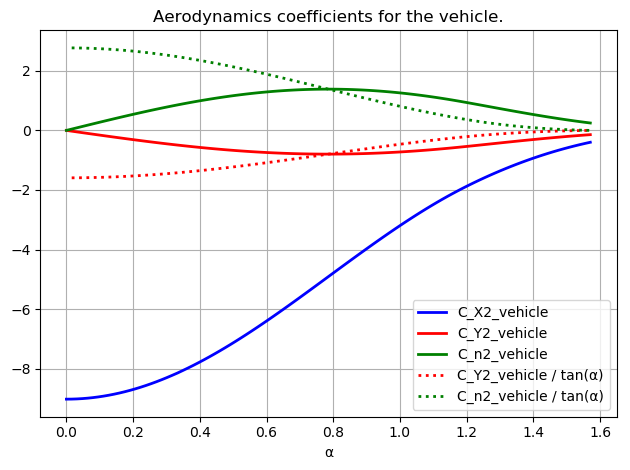

In [4]:
function plot_aerodynamics_ceofficients(r_max, r_min, l, x_g, num_nodes; display=true)
    α_vect = range(0, stop=pi/2, length=num_nodes)
    C_F2_vect = zeros(num_nodes, 3)
    C_τ2_vect = zeros(num_nodes, 3)
    for i=1:num_nodes
        C_F2_vect[i, :], C_τ2_vect[i, :] = aerodynamics_coefficents(α_vect[i], r_max, r_min, l, x_g)
    end
    plot(α_vect, C_F2_vect[:, 1], color="blue", linewidth=2.0, linestyle="-", label="C_X2_vehicle")
    plot(α_vect, C_F2_vect[:, 2], color="red", linewidth=2.0, linestyle="-", label="C_Y2_vehicle")
    plot(α_vect, C_τ2_vect[:, 3], color="green", linewidth=2.0, linestyle="-", label="C_n2_vehicle")
    plot(α_vect, C_F2_vect[:, 2] ./ tan.(α_vect), color="red", linewidth=2.0, linestyle=":", label="C_Y2_vehicle / tan(α)")
    plot(α_vect, C_τ2_vect[:, 3] ./ tan.(α_vect), color="green", linewidth=2.0, linestyle=":", label="C_n2_vehicle / tan(α)")
    legend()
    xlabel("α")
    title("Aerodynamics coefficients for the vehicle.")
    grid("on")
    if display 
        tight_layout()
        show()
    end
    return
end

num_nodes = 100
plot_aerodynamics_ceofficients(r_max, r_min, l, x_g, num_nodes; display=true)

### Simplified Dynamics Model
- We assume flat planet model, gravity acceleration is directed along the x axis.
- We assume constant uniform of the atmosphere.
- We assume that the fluid is static.

In [54]:
## Utilities
"""
@(SIGNATURES)
    Conjuguate of a quaternion. 
"""
function qconj(q)
    p = q
    p[2:4] = - q[2:4]
return p / norm(q)^2
end

"""
@(SIGNATURES)
    Rotate a vector by a quaternion
"""
function qrot(q,r)
    r + 2*cross(q[2:4],cross(q[2:4],r) + q[1]*r)
end

"""
@(SIGNATURES)
    Multiplication of two quaternions (q = [s;v])
"""
function qmult(q1,q2)
    [q1[1]*q2[1] - q1[2:4]'*q2[2:4]; q1[1]*q2[2:4] + q2[1]*q1[2:4] + cross(q1[2:4],q2[2:4])]
end

function entry_vehicle_dynamics!(ẋ,X,u)
    ## States: X ∈ R^13; q = [s;v]
    # x
    # y
    # z
    # q0
    # q1
    # q2
    # q3
    # xdot
    # ydot
    # zdot
    # omega1
    # omega2
    # omega3

    x = X[1:3]
    q = X[4:7]./norm(X[4:7]) #normalize quaternion
    v = X[8:10]
    ω = X[11:13]

    # Parameters
    r_min = 0.20 # smallest radius of the cone [m]
    r_max = 1.30 # largest radius of the cone [m]
    l = 0.55 # length of the cone [m]
    m = 569.7 # mass of the Phoenix entry system [kg]
    x_g = -0.152 # axial center-of-gravity location [m]
    Jxx = 293.15 # Phoenix entry system [kg.m^2]
    Jyy = 184 # Phoenix entry system [kg.m^2]
    Jzz = 208.02 # Phoenix entry system [kg.m^2]
    Jxy = 0.451 # Phoenix entry system [kg.m^2]
    Jxz = -4.424 # Phoenix entry system [kg.m^2]
    Jyz = 0.372 # Phoenix entry system [kg.m^2]
    J = Matrix([Jxx Jxy Jxz; Jxy Jyy Jyz; Jxz Jyz Jzz])# Inertia matrix [kg.m^2]
    Jinv = inv(J) # inverted inertia matrix [kg^-1.m^-2]
    g = 3.711 # Mars gravity [m^2.s^-1]
    h = 10800 # Atmospheric Scale Height [m]
    ρ_0 = 0.020 # Surface density of Mars atmosphere [kg.m^-3]
    r_p = 3389.5e3 # Volumetric mean radius of Mars [m]
    ω_p = [0, 0, 7.088e-05] # Angular velocity of Mars [rad.s^-1]

    # Mars atmosphere model
    # altitude = norm(x) - r_p
    # Uniform density assumption
    ρ_inf = ρ_0 #* exp(- altitude / h)

    # Freestream Velocity
    # Static fluid assumption
    V_inf = - qrot(qconj(q), v) # - qrot(qconj(q), v + cross(x, ω_p))

    # This rotation matrix includes the 1/tan(α) terms required to rescale the aerodynamics 
    # coefficients C_Y2 and C_n2.
    s_cos_θ = V_inf[2] / V_inf[1]
    s_sin_θ = V_inf[3] / V_inf[1]
    Rot_2_1 = [1 0 0; 0 s_cos_θ -s_sin_θ; 0 s_sin_θ s_cos_θ]
    # Since α ∈ [0, π/2[ we can use atan with one variable, it is differentiable in 0.
    ϵ = 1e-100
    α = atan(sqrt(V_inf[2]^2 + V_inf[3]^2 + ϵ^2) - ϵ / V_inf[1])
    
    # Aerodynamic Forces and Moments in Freestream frame
    C_F2, C_τ2 = aerodynamics_coefficents_chebyshev_tan(α, r_max, r_min, l, x_g)

    F_2 = 1.0/2 * ρ_inf * norm(V_inf)^2 * C_F2
    τ_2 = 1.0/2 * ρ_inf * norm(V_inf)^2 * C_τ2

    F_a = Rot_2_1 * F_2
    τ_a = Rot_2_1 * τ_2

    # Control forces and moments in body_frame
    F_c = zeros(3)
    τ_c = zeros(3)

    # Forces and moments in body-frame
    F = F_a + F_c
    τ = τ_a + τ_c
#     print("F", F)
#     print("τ", τ)

    ẋ[1:3] = v # velocity in world frame
    ẋ[4:7] = 0.5 * qmult(q, [0; ω]) #quaternion derivative
    ẋ[8:10] = +[g, 0, 0] + (1 / m) * qrot(q, F) # -g * x /norm(x) + (1/m)*qrot(q,F) #acceleration in world frame
    ẋ[11:13] = Jinv * (τ - cross(ω , J * ω)) #Euler's equation: I*ω + ω x I*ω = constraint_decrease_ratio
    return ẋ, V_inf
end

function open_loop_entry_vehicle_dynamics(X::Vector)
    u = zeros(4,1)
    ẋ = X - X
    return entry_vehicle_dynamics!(ẋ,X,u)[1]
end

A = ForwardDiff.jacobian(open_loop_entry_vehicle_dynamics, X_eq)

for i=1:size(A)[1]
    println("A ", A[i, :])
end

open_loop_entry_vehicle_dynamics(X_eq)

# index_removed = [1, 4, 8]
# index_removed = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
index_removed = []

A_filtered = A[setdiff(1:end, index_removed), setdiff(1:end, index_removed)];


# variables = ["A_y", "A_z", "A_q2", "A_q3", "A_q4", "A_ydot", "A_zdot", "A_w1", "A_w2", "A_w3"]
# for i=1:10
#     println(variables[i], A_filtered[i, :])
# end
# println("eigvals(A_filtered)", eigvals(A_filtered))
# for i=1:10
#     println("eigvecs(A_filtered)", eigvecs(A_filtered)[i, :])
# end


A [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
A [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
A [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
A [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
A [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0]
A [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0]
A [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5]
A [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.316817, 0.0, 0.0, 0.0, 0.0, 0.0]
A [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 372.72, 0.0, -0.0279512, 0.0, 0.0, 0.0, 0.0]
A [0.0, 0.0, 0.0, 0.0, 0.0, -372.72, 0.0, 0.0, 0.0, -0.0279512, 0.0, 0.0, 0.0]
A [0.0, 0.0, 0.0, 0.0, 0.0, 0.471576, -4.02198, 0.0, 0.00201099, 0.000235788, 0.0, 0.0, 0.0]
A [0.0, 0.0, 0.0, 0.0, 0.0, -301.143, 0.548561, 0.0, -0.00027428, -0.150572, 0.0, 0.0, 0.0]
A [0.0, 0.0, 0.0, 0.0, 0.0, 0.548561, -266.455, 0.0, 0.133227, 0.00027428, 0.0, 0.0, 0.0]


In [55]:
# A_filtered[:, 1:2]
A_filtered

13×13 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0     0.0       …   0.0          0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0     0.0           0.0          0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0     0.0           1.0          0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0     0.0           0.0          0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0     0.0           0.0          0.5  0.0  0.0
 0.0  0.0  0.0  0.0  0.0     0.0       …   0.0          0.0  0.5  0.0
 0.0  0.0  0.0  0.0  0.0     0.0           0.0          0.0  0.0  0.5
 0.0  0.0  0.0  0.0  0.0     0.0           0.0          0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0     0.0           0.0          0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  -372.72         -0.0279512    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0     0.471576  …   0.000235788  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  -301.143        -0.150572     0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0     0.548561      0.00027428   0.0  0.0  0.0

In [56]:
eigvals(A_filtered)

13-element Array{Complex{Float64},1}:
                  0.0 + 0.0im               
                  0.0 + 0.0im               
                  0.0 + 0.0im               
                  0.0 + 0.0im               
 -0.09316446166403675 + 12.271791615994582im
 -0.09316446166403675 - 12.271791615994582im
 -0.09316244143702146 + 11.543135986220456im
 -0.09316244143702146 - 11.543135986220456im
  0.15837768894288146 + 0.0im               
   0.1583736484888545 + 0.0im               
                  0.0 + 0.0im               
                  0.0 + 0.0im               
  -0.3168174565559539 + 0.0im               

In [58]:
eigvecs(A_filtered)[:, 9:10]

13×2 Array{Complex{Float64},2}:
         0.0+0.0im          0.0+0.0im
   0.0156134+0.0im     0.987567+0.0im
    0.987566+0.0im   -0.0156134+0.0im
         0.0+0.0im          0.0+0.0im
   1.3895e-7+0.0im   1.17805e-6+0.0im
 -7.81912e-5+0.0im   1.23614e-6+0.0im
   1.2362e-6+0.0im   7.81875e-5+0.0im
         0.0+0.0im          0.0+0.0im
  0.00247282+0.0im     0.156405+0.0im
    0.156408+0.0im  -0.00247275+0.0im
  4.40131e-8+0.0im   3.73143e-7+0.0im
 -2.47675e-5+0.0im   3.91545e-7+0.0im
  3.91574e-7+0.0im   2.47657e-5+0.0im

In [52]:
eigvecs(A_filtered)[:, :]

13×13 Array{Complex{Float64},2}:
 0.0+0.0im           0.0+0.0im  …      0.953301+0.0im  0.0+0.0im
 0.0+0.0im           0.0+0.0im     -1.53178e-13+0.0im  0.0+0.0im
 0.0+0.0im           0.0+0.0im     -6.97612e-18+0.0im  0.0+0.0im
 0.0+0.0im           0.0+0.0im              0.0+0.0im  1.0+0.0im
 1.0+0.0im          -1.0+0.0im       1.2619e-16+0.0im  0.0+0.0im
 0.0+0.0im           0.0+0.0im  …   1.31154e-21+0.0im  0.0+0.0im
 0.0+0.0im           0.0+0.0im      2.60749e-18+0.0im  0.0+0.0im
 0.0+0.0im           0.0+0.0im        -0.302022+0.0im  0.0+0.0im
 0.0+0.0im           0.0+0.0im      2.83246e-16+0.0im  0.0+0.0im
 0.0+0.0im           0.0+0.0im      1.27255e-18+0.0im  0.0+0.0im
 0.0+0.0im  2.60542e-291+0.0im  …  -7.99586e-17+0.0im  0.0+0.0im
 0.0+0.0im           0.0+0.0im     -1.11124e-19+0.0im  0.0+0.0im
 0.0+0.0im           0.0+0.0im      1.53143e-17+0.0im  0.0+0.0im

In [32]:
eigvecs(A_filtered)[:, 1:3]

10×3 Array{Complex{Float64},2}:
 0.0+0.0im           0.0+0.0im   -0.00056704-0.0702581im  
 0.0+0.0im           0.0+0.0im    8.96489e-6+0.00111078im 
 1.0+0.0im          -1.0+0.0im   -2.13802e-6+0.000378455im
 0.0+0.0im           0.0+0.0im   -2.24347e-6+0.00039712im 
 0.0+0.0im           0.0+0.0im  -0.000141902+0.0251183im  
 0.0+0.0im           0.0+0.0im      0.811051+0.0im        
 0.0+0.0im           0.0+0.0im    -0.0128227+3.70458e-17im
 0.0+0.0im  2.00417e-291+0.0im   -0.00873672-0.000119875im
 0.0+0.0im           0.0+0.0im   -0.00916759-0.000125787im
 0.0+0.0im           0.0+0.0im     -0.579861-0.00795614im 

In [33]:
eigvecs(A_filtered)[:, 4:5]

10×2 Array{Complex{Float64},2}:
  -0.00056704+0.0702581im     7.58801e-6+0.000999506im
   8.96489e-6-0.00111078im    0.00047995+0.0632199im  
  -2.13802e-6-0.000378455im   2.41235e-7-4.53955e-5im 
  -2.24347e-6-0.00039712im   -0.00013575+0.0255454im  
 -0.000141902-0.0251183im     2.14621e-6-0.000403872im
     0.811051-0.0im           -0.0122664-6.72612e-17im
   -0.0128227-3.70458e-17im    -0.775866+0.0im        
  -0.00873672+0.000119875im   0.00111412+1.43793e-5im 
  -0.00916759+0.000125787im     -0.62695-0.00809163im 
    -0.579861+0.00795614im    0.00991207+0.000127929im

In [34]:
eigvecs(A_filtered)[:, 6:7]

10×2 Array{Complex{Float64},2}:
  7.58801e-6-0.000999506im    -0.987563+0.0im
  0.00047995-0.0632199im      0.0156134+0.0im
  2.41235e-7+4.53955e-5im   -1.17822e-6+0.0im
 -0.00013575-0.0255454im    -1.23632e-6+0.0im
  2.14621e-6+0.000403872im  -7.81988e-5+0.0im
  -0.0122664+6.72612e-17im    -0.156427+0.0im
   -0.775866-0.0im           0.00247311+0.0im
  0.00111412-1.43793e-5im   -3.73252e-7+0.0im
    -0.62695+0.00809163im    -3.9166e-7+0.0im
  0.00991207-0.000127929im  -2.47729e-5+0.0im

In [35]:
eigvecs(A_filtered)[:, 8:10]

10×3 Array{Complex{Float64},2}:
   0.0156134+0.0im     -0.999984+0.0im     0.0186729+0.0im
    0.987562+0.0im   -0.00562131+0.0im     -0.999826+0.0im
   1.3897e-7+0.0im   1.76711e-10+0.0im   1.52353e-11+0.0im
 -7.82025e-5+0.0im  -6.58348e-11+0.0im   -1.17096e-8+0.0im
  1.23638e-6+0.0im    1.17115e-8+0.0im   -2.1869e-10+0.0im
  0.00247317+0.0im    2.34229e-5+0.0im    -4.3738e-7+0.0im
    0.156431+0.0im     1.3167e-7+0.0im    2.34192e-5+0.0im
   4.4026e-8+0.0im  -8.27829e-15+0.0im  -7.13721e-16+0.0im
 -2.47747e-5+0.0im   3.08414e-15+0.0im   5.48554e-13+0.0im
  3.91688e-7+0.0im  -5.48641e-13+0.0im   1.02449e-14+0.0im

In [36]:
A_filtered * eigvecs(A_filtered)[:, 8]

10-element Array{Complex{Float64},1}:
  0.0024731726140510154 + 0.0im
    0.15643097450011026 + 0.0im
  2.2013001175472596e-8 + 0.0im
  -1.238735567421062e-5 + 0.0im
  1.9584400667368883e-7 + 0.0im
 0.00039175328142806456 + 0.0im
   0.024778839628595874 + 0.0im
    6.97376753701584e-9 + 0.0im
 -3.9243417188777885e-6 + 0.0im
   6.204381515938684e-8 + 0.0im